In [3]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

In [4]:
wage_df = pd.read_csv('Wage.csv')
wage_df = wage_df.drop(wage_df.columns[0], axis=1)

wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [5]:
def ols_cv(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)

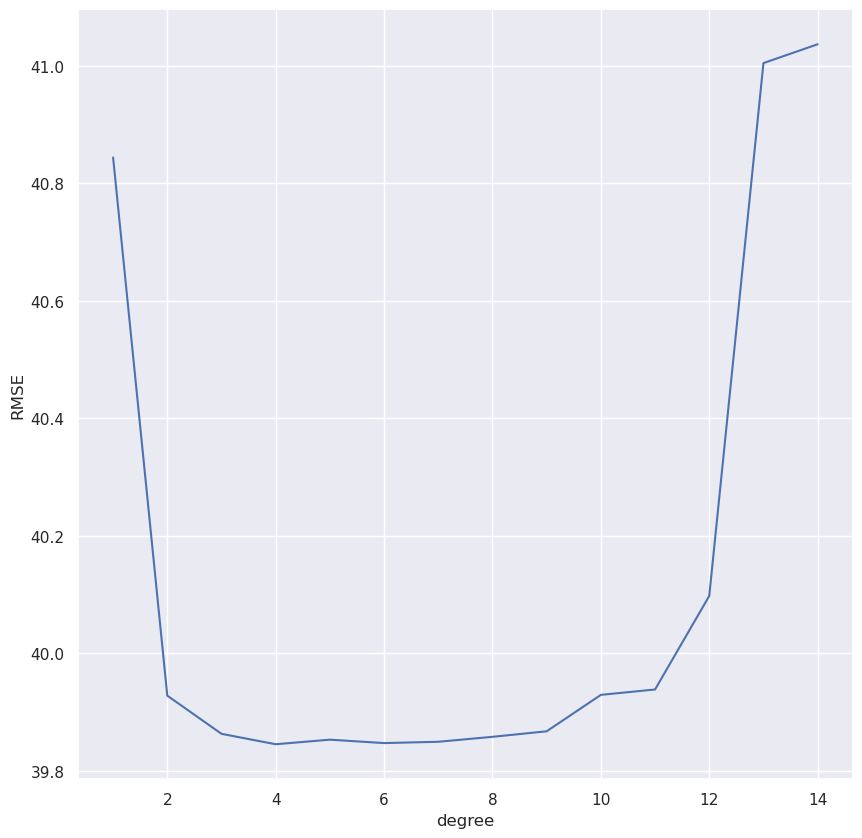

Min RMSE : 39.845207021191335
Degree   : 4


In [11]:
# Perform CV for increasing polynomial order
results = [] 
for d in np.arange(1,15):
    f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, d+1)])
    X = pt.dmatrix(f, wage_df)
    y = np.asarray(wage_df['wage'])
    results += [(ols_cv(f, X, y, 10)[0], d)]
    
# Plot the results
df = pd.DataFrame({'RMSE': [r[0] for r in results],
                   'degree': [r[1] for r in results]})   
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='degree', y='RMSE', data=df, color='b', ax=ax)
plt.show();

# Choose model
print('Min RMSE : {}'.format(min(results)[0]))
print('Degree   : {}'.format(min(results)[1]))

In [13]:
# Derive 5 degree polynomial features of age
degree = 5
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, wage_df)
y = np.asarray(wage_df['wage'])

# Get models of increasing degrees
model_1 = sm.OLS(y, X[:, 0:2]).fit()
model_2 = sm.OLS(y, X[:, 0:3]).fit()
model_3 = sm.OLS(y, X[:, 0:4]).fit()
model_4 = sm.OLS(y, X[:, 0:5]).fit()
model_5 = sm.OLS(y, X[:, 0:6]).fit()

# Compare models with ANOVA
display(sm.stats.anova_lm(model_1, model_2, model_3, model_4, model_5))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


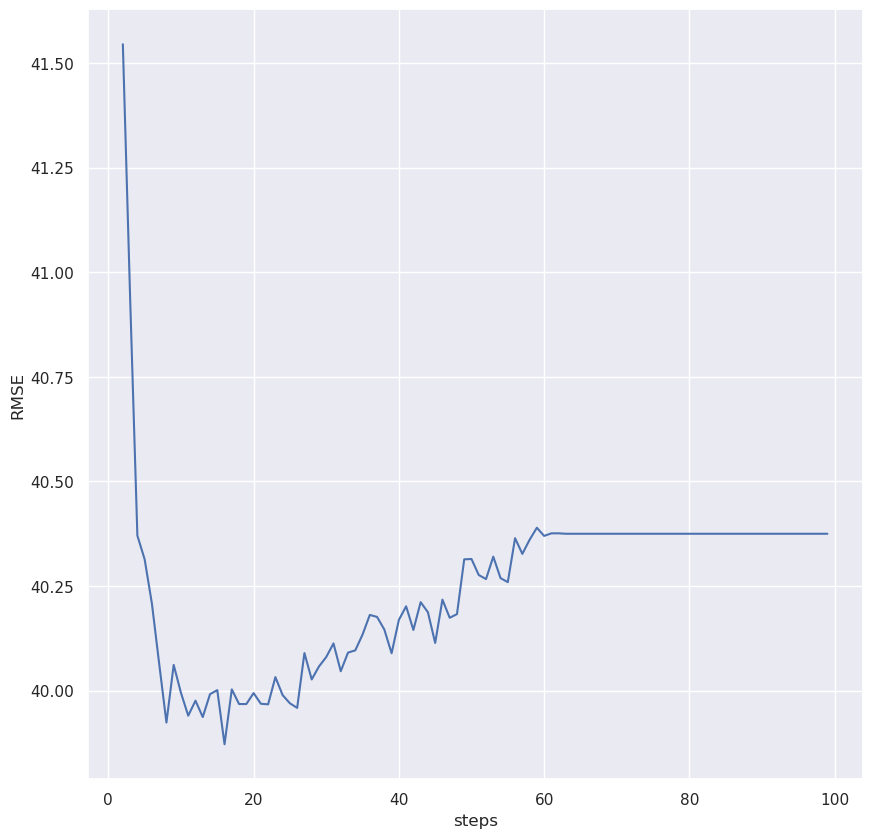

Min RMSE : 39.872054703507914
Steps   : 16


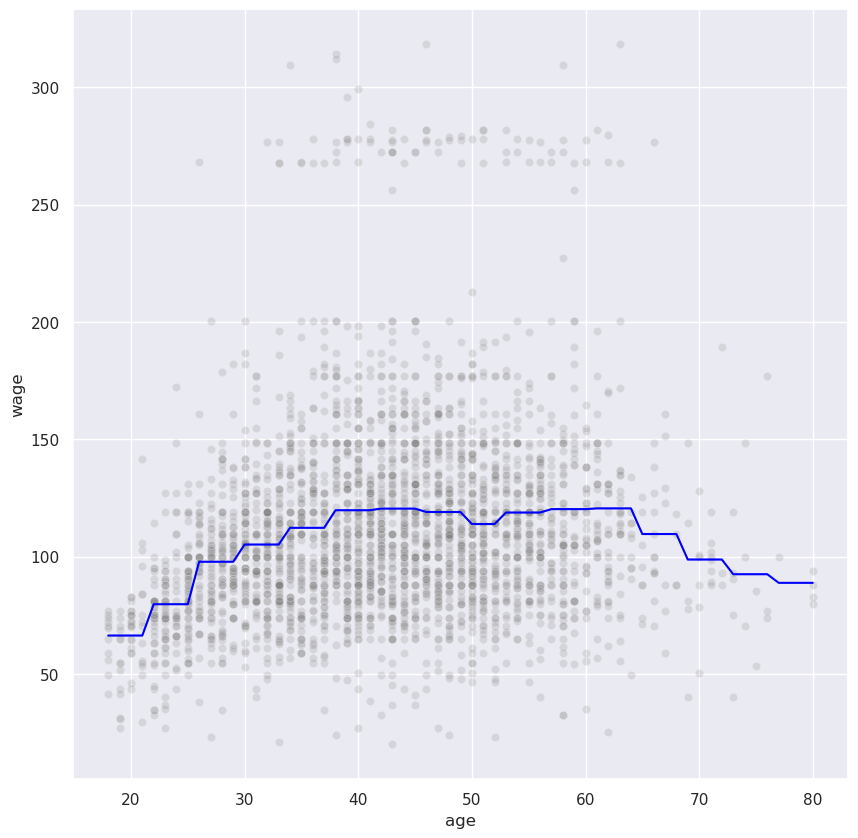

In [17]:
# CHOOSE BEST MODEL
# ----------------------------------

results = [] 
for steps in np.arange(2,100):
    # Segment data into 4 segments by age
    cuts = pd.cut(wage_df['age'], steps)
    X = np.asarray(pd.get_dummies(cuts))
    y = np.asarray(wage_df['wage'])
    results += [(ols_cv(f, X, y, 10)[0], steps)]
    
# Plot the results
df = pd.DataFrame({'RMSE': [r[0] for r in results],
                   'steps': [r[1] for r in results]})   
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='steps', y='RMSE', data=df, color='b', ax=ax)
plt.show();

# Choose model
print('Min RMSE : {}'.format(min(results)[0]))
print('Steps   : {}'.format(min(results)[1]))


# PLOT BEST MODEL
# ----------------------------------
steps = min(results)[1]

# Segment data into 4 segments by age
cuts = pd.cut(wage_df['age'], steps)
X = np.asarray(pd.get_dummies(cuts))
y = np.asarray(wage_df['wage'])

# Fit logistic regression model
model = sm.OLS(y, X).fit(disp=0)
y_hat = model.predict(X)


# Setup axes
fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=pd.concat([wage_df['age'], wage_df['wage']], axis=1));

# Plot estimated f(x)
sns.lineplot(x=wage_df['age'], y=y_hat, ax=ax, color='blue')
plt.show();

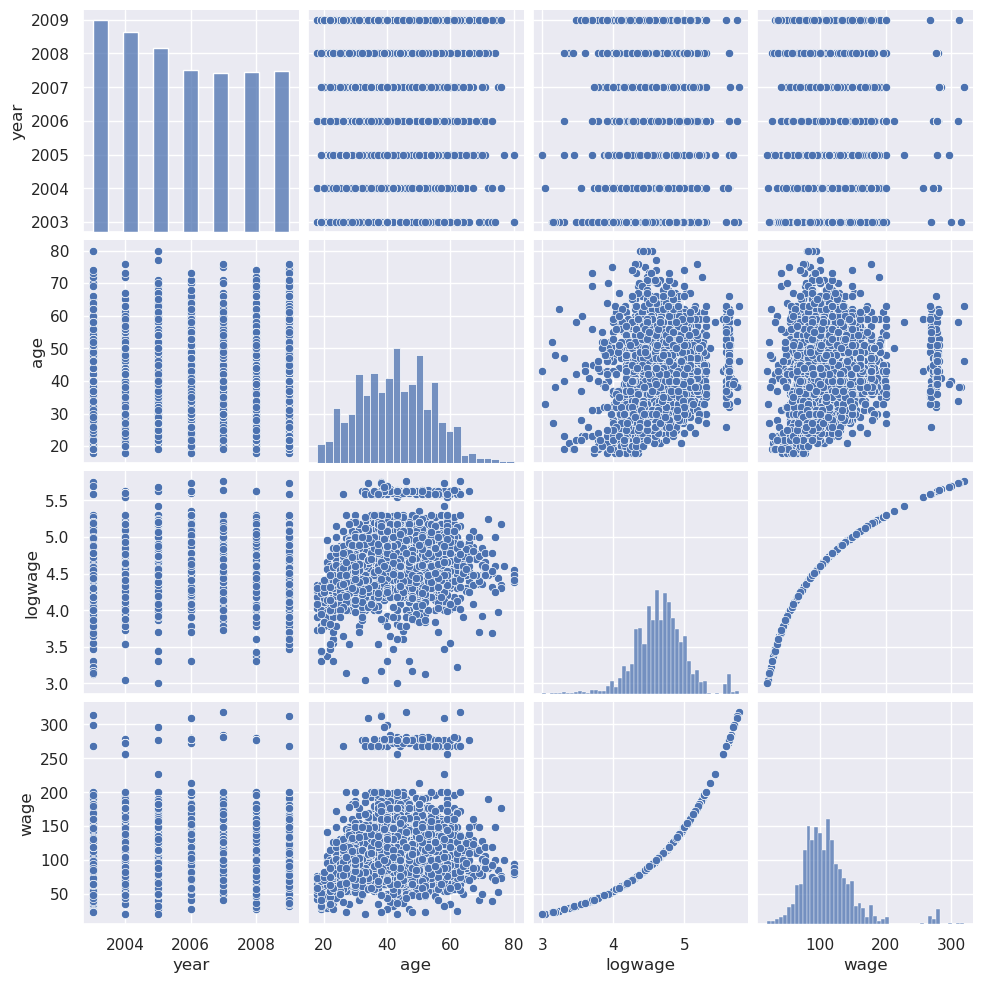

In [19]:
sns.pairplot(data=wage_df);

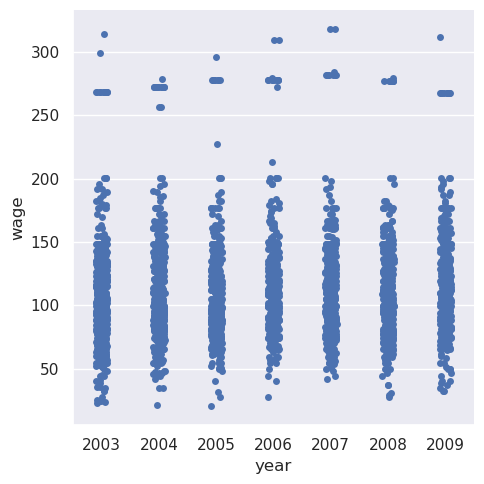

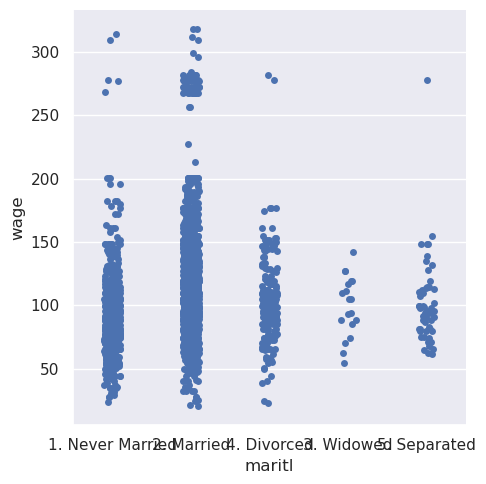

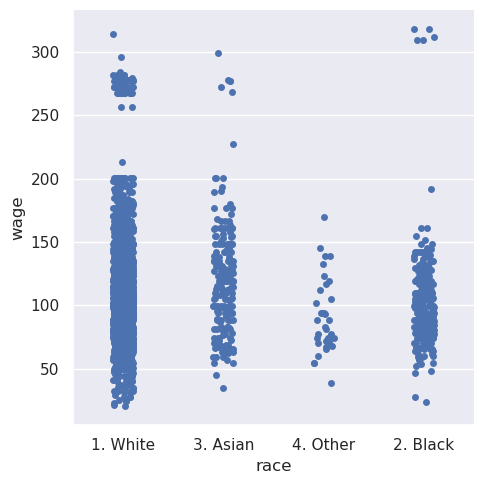

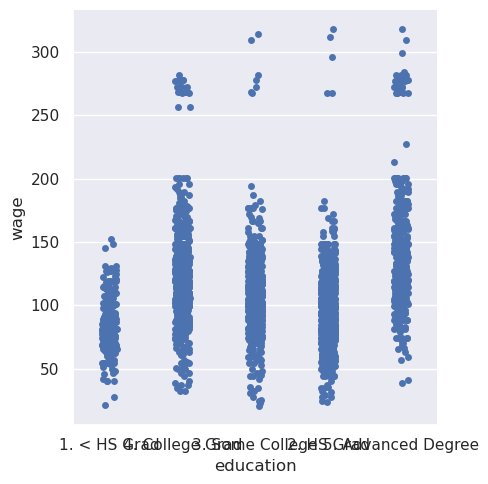

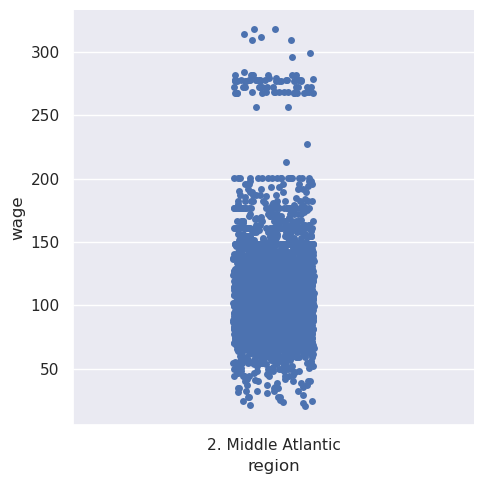

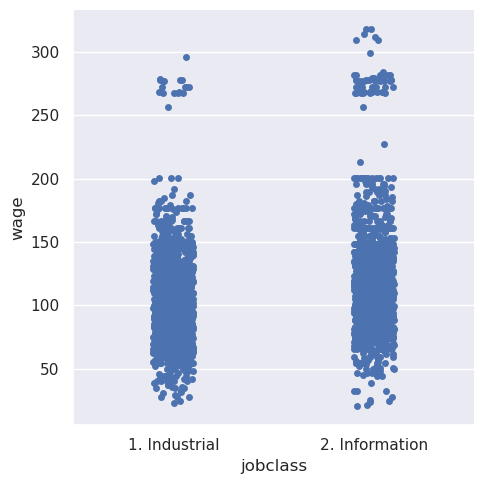

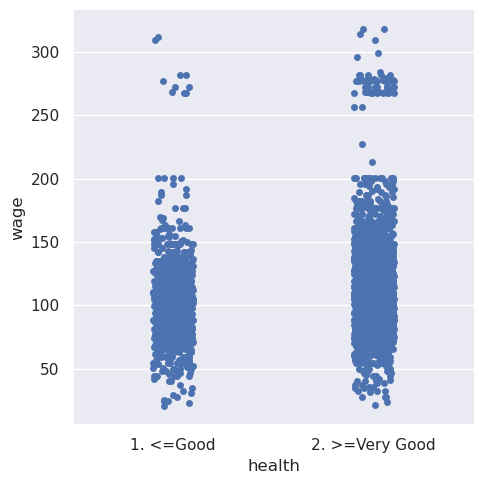

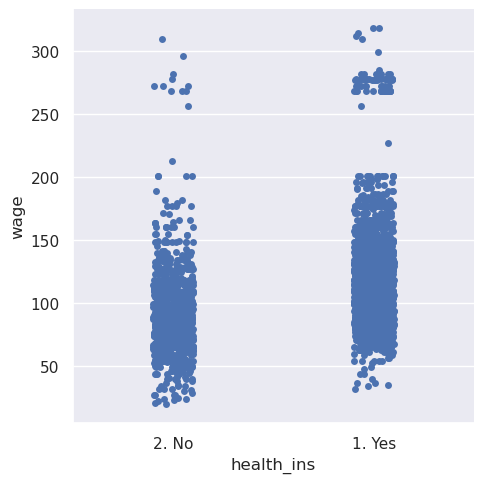

In [20]:
categoricals = wage_df.drop(['age', 'logwage', 'wage'], axis=1).columns
for c in categoricals:
    sns.catplot(x=c, y='wage', data=wage_df)

In [22]:
wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [27]:
# Treat education as ordinal
wage_df['education'] = wage_df['education'].map({'1. < HS Grad': 1.0, 
                                                 '2. HS Grad': 2.0, 
                                                 '3. Some College': 3.0,
                                                 '4. College Grad': 4.0,
                                                 '5. Advanced Degree': 5.0
                                                })
wage_df.head()


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,NaN,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,NaN,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,NaN,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,NaN,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,NaN,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [37]:
def ols_cv(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)

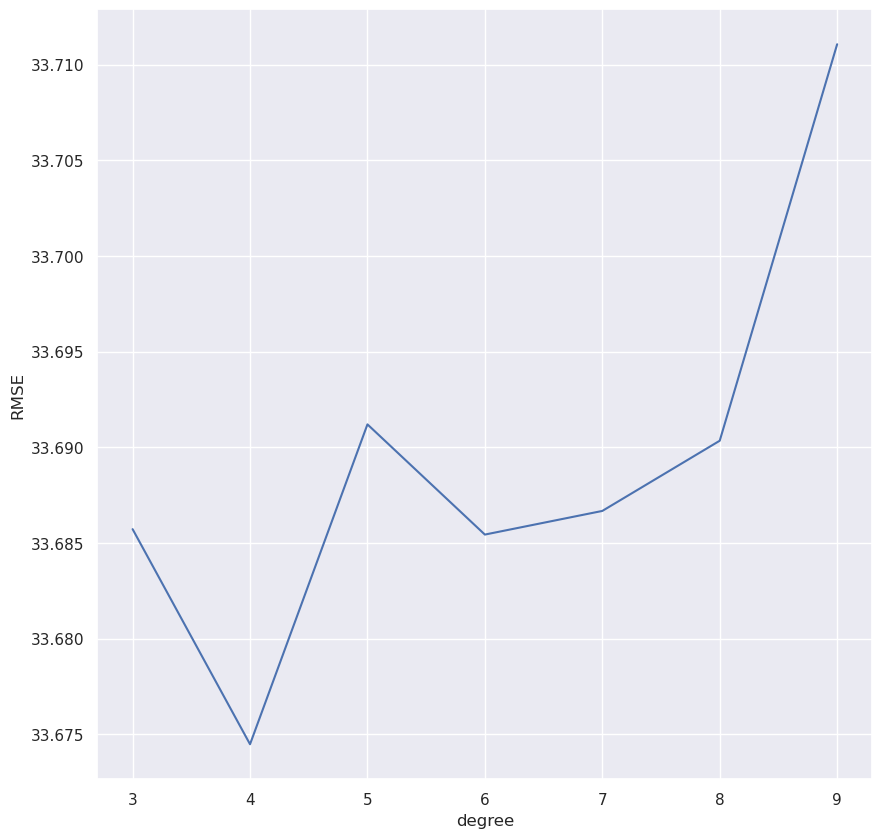

Min RMSE : 33.67447546449712
Degree   : 4


In [9]:
# Perform CV for increasing polynomial order
results = [] 
for d in np.arange(3,10):
    f = 'year + education + cr(age, df={}) + C(maritl) + C(race) + C(jobclass) + C(health) + C(health_ins)'.format(d)
    X = pt.dmatrix(f, wage_df)
    y = np.asarray(wage_df['wage'])
    results += [(ols_cv(f, X, y, 10)[0], d)]
    
# Plot the results
df = pd.DataFrame({'RMSE': [r[0] for r in results],
                   'degree': [r[1] for r in results]})   
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='degree', y='RMSE', data=df, color='b', ax=ax)
plt.show();

# Choose model
print('Min RMSE : {}'.format(min(results)[0]))
print('Degree   : {}'.format(min(results)[1]))

In [57]:
def backward_stepwise_patsy(predictors, response, data, scorer='ssr', results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all = predictors

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(response, '+'.join(p_all))
        model = smf.ols(formula=f, data=data).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(response, '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=data).fit()
        r     += [(model, p_test)]
    
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return backward_stepwise_patsy(predictors, response, data, scorer, new_results)


def subset_analysis(df, scorer):
    """Renders results from forward_stepwise() and backward_stepwise()"""
    df['predictors_str'] = df['predictors'].astype(str)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.lineplot(x='predictors_str', y=scorer, data=df, sort=False, ax=ax)
    plt.xticks(rotation=90)
    plt.show();
    
    if scorer == 'rsquared_adj':
        display(df[df[scorer] ==  df[scorer].max()].drop('predictors_str', axis=1))
        return df
    else:
        display(df[df[scorer] ==  df[scorer].min()].drop('predictors_str', axis=1))
        return df

        
def ols_cv_patsy(formula, data, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    y, X = pt.dmatrices(formula, wage_df)
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)

In [14]:
np.random.seed(1)
x1  = np.random.normal(0, 1, 100)
x2  = np.random.normal(0, 1, 100)
eps = 0.1 * np.random.normal(0, 1, 100)

X = np.asarray([np.ones(100), x1, x2]).T
y = 0.2 + 2*x1 + 5*x2 + eps

In [69]:
beta1 = 20
ya = y - (beta1*x1)
Xa = np.asarray([np.ones(100), x2]).T

# Fit using Ordinary Least Squares regression
beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
print(beta_hat)

beta2 = beta_hat[1]

[-0.65602756  3.47192688]


In [71]:
ya = y - (beta2*x2)
Xa = np.asarray([np.ones(100), x1]).T

beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
print(beta_hat)

#beta1 = beta_hat[1]

[0.42587836 2.14171377]


In [73]:
beta1 = 100

results= []
for i in range(20):
    # Keeping beta1 fixed, fit the model to estimate beta2
    ya = y - (beta1*x1)
    Xa = np.asarray([np.ones(100), x2]).T
    
    beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya 
    beta2 = beta_hat[1]
    
    # Keeping beta2 fixed, fit the model beta1
    ya = y - (beta2*x2)
    Xa = np.asarray([np.ones(100), x1]).T
    
    beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
    beta1 = beta_hat[1]
    beta0 = beta_hat[0]
    results += [[beta0, beta1, beta2]]

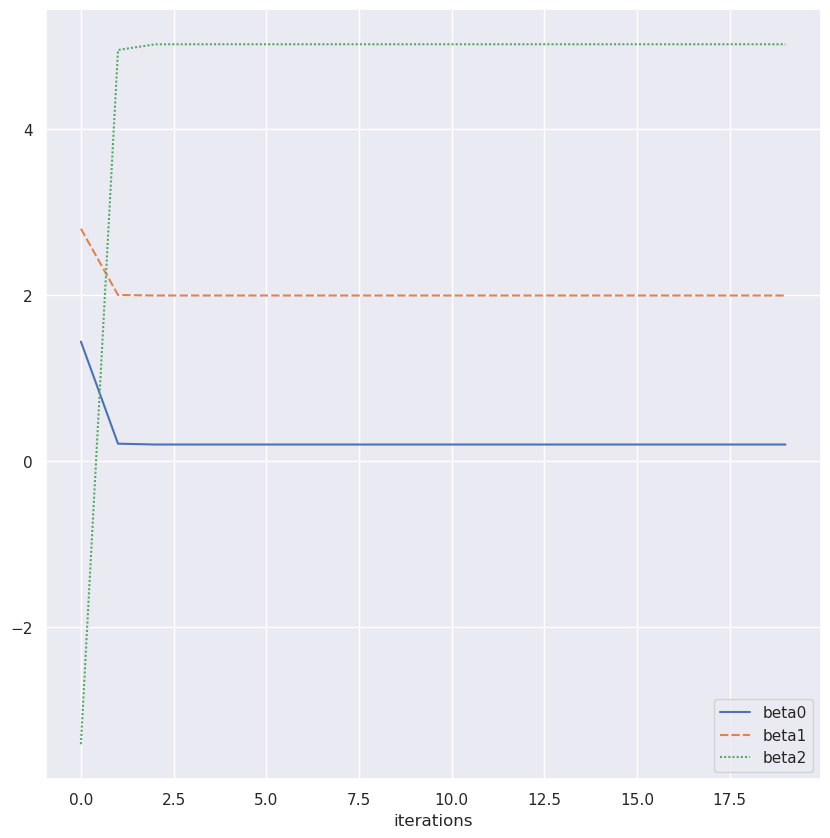

In [75]:
fig = plt.figure(figsize=(10, 10))
sns.lineplot(data=pd.DataFrame(np.asarray(results), columns=['beta0','beta1','beta2']))
plt.xlabel('iterations');

In [77]:
# A multivariate regression for ref
beta_hat = (np.linalg.inv((X.T @ X)) @ X.T) @ y
beta_hat

array([0.19802058, 1.99381028, 5.02183714])

In [81]:
def gen_data(n, p):
    """Generate simulated data from normal distribution where:
    - n is number of observations
    - p is number of predictors
    
    Returns
    X, design matrix of predictors with bias variable
    y, response variable from linear model
    beta_true, the true coefficients of the linear model used to derive y from X
    beta_rand, a random vector of shape beta_true, useful as starting point for iterative estimatation
    """
    np.random.seed(1)
    # Generate 100 random observations for 100 predictors
    predictors = np.random.normal(0, 1, (n, p))
    # Add bias variable
    X = np.insert(predictors, 0, 1, axis=1)
    # Generate random beta coefficients
    beta_true = np.random.randint(0, 10, size=X.shape[1]).astype(np.float64)
    # Derive true y
    eps = 0.1* np.random.normal(0, 1, n)
    y = beta_true @ X.T + eps
    
    # Initalize beta at some random values
    beta_rand = list(np.random.randint(0, 10, size=X.shape[1]).astype(np.float64))
    
    return X, y, beta_true, beta_rand


def backfit(X, y, iterations:int, beta_ests:list):
    """Perform backfitting algorithm to recursively estimate
    beta parameters one at a time"""
    
    # Exit recursion
    if len(beta_ests) == iterations:
        return np.asarray(beta_ests)
    
    # Start recursion or iterate 
    beta_prev = copy.deepcopy(beta_ests[-1])
    beta_new  = np.zeros(len(beta_prev))
    
    # Perform one backfitting iteration to generate new set of estimates for all beta
    for j in  np.arange(1, X.shape[1]):
        # - Exclude predictors for which params are not being estimated in this pass (except intercept)
        # - Isolate predictors for which param is to be estimated in this pass
        # - Perform Ordinary Least Squares regression
        y_b = y - (np.delete(beta_prev[1:], j-1) @ np.delete(X[:, 1:], j-1, axis=1).T)
        X_b = X[:, [0,j]]
        beta_est = (np.linalg.inv((X_b.T @ X_b)) @ X_b.T) @ y_b
        
        # Save estimates, but include intercept estimate on first pass only
        if j == 1:
            beta_new[0] = beta_est[0]
            beta_new[1] = beta_est[1]
        else:
            beta_new[j] = beta_est[1]
    
    # Recur
    return backfit(X, y, iterations, beta_ests+[beta_new])


def backfit_plot(n, p, iterations):
    """Plot coefficient estimates for each iteration of backfitting for simulated data:
    - n is number of observations
    - p is number of predictors
    - iterations is number of backfitting iterations
    """
    # Gen simulated data
    X, y, beta_true, beta_rand = gen_data(n, p)
    
    beta_ests = backfit(X, y, iterations, [beta_rand])
    cols = ['x{}'.format(i) for i in range(p+1)]
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(p+1):
        # Plot estimated coefficient
        sns.lineplot(data=beta_ests[:, i]);
        # Plot true coefficient
        plt.axhline(y=beta_true[i], linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel('coefficients (β)')
    plt.show();
    #return beta_ests

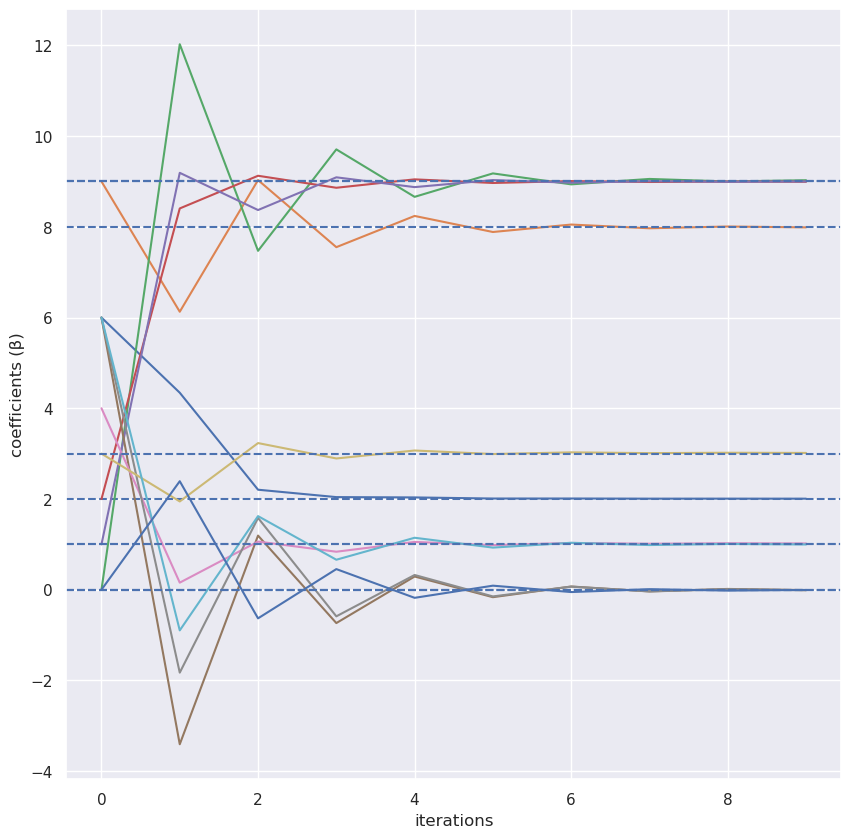

In [83]:
backfit_plot(n=100, p=10, iterations=10);

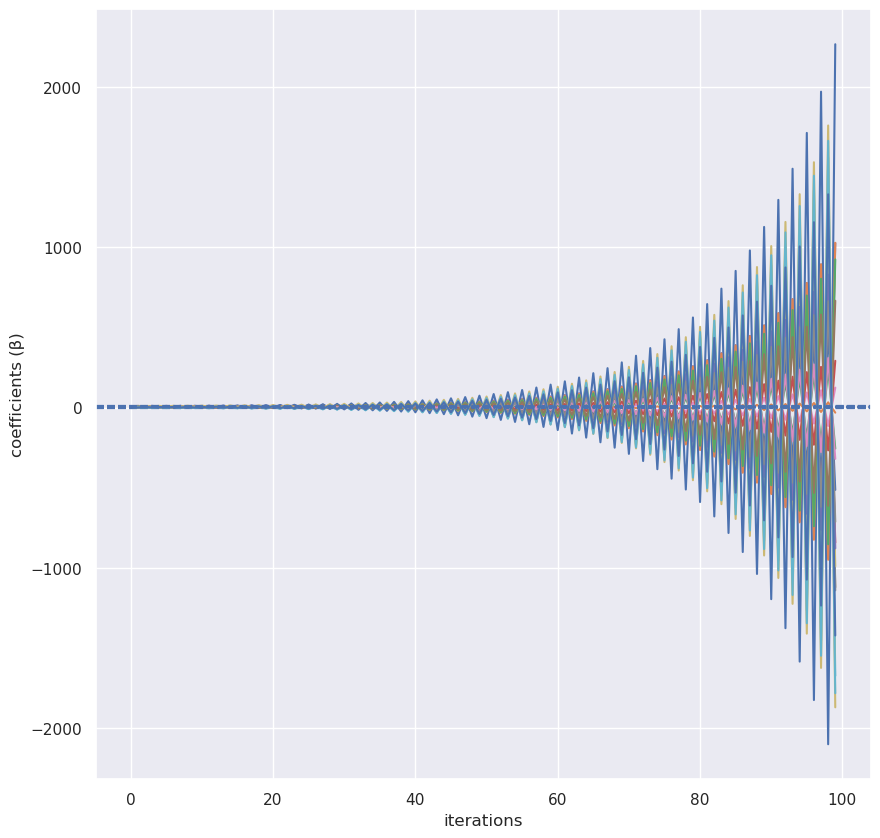

In [88]:
backfit_plot(n=100, p=20, iterations=100);

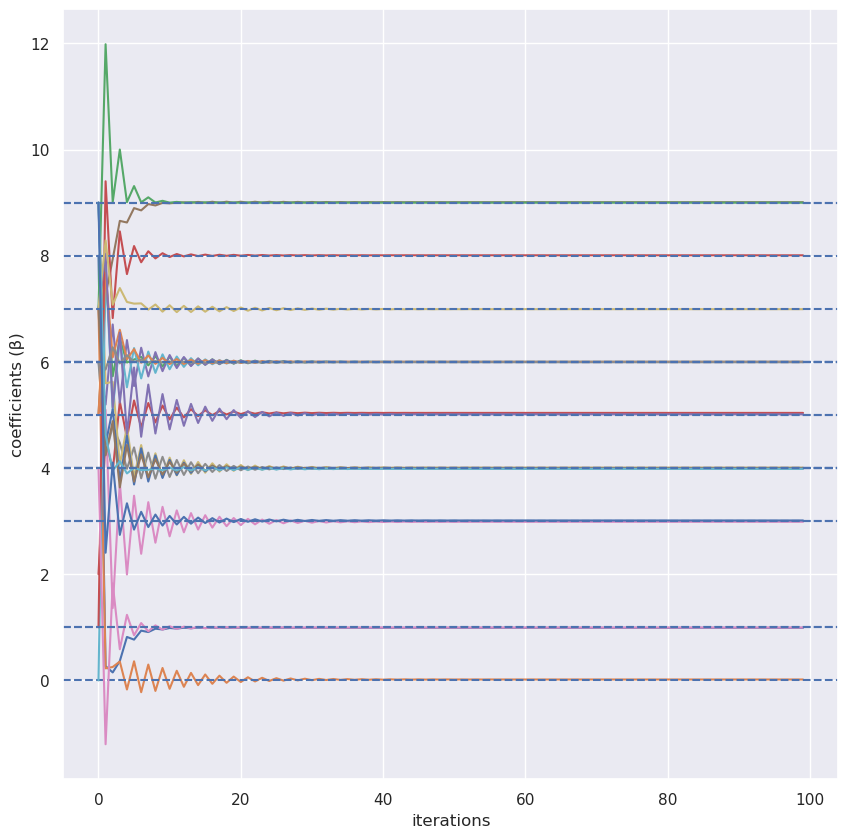

In [90]:
backfit_plot(n=120, p=20, iterations=100);


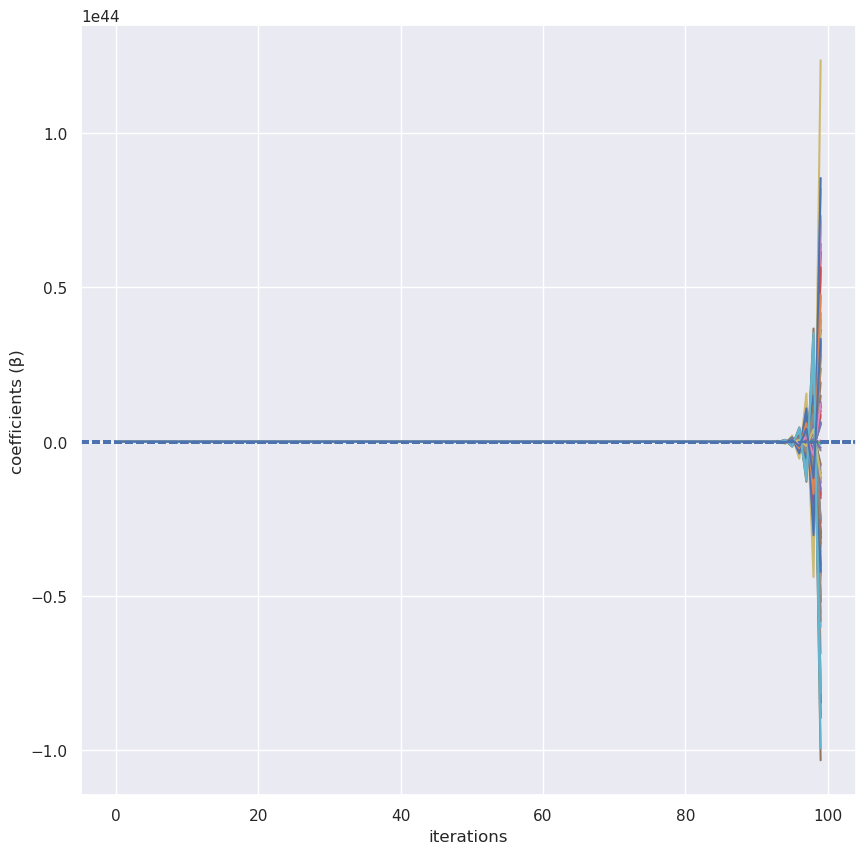

In [92]:
backfit_plot(n=100, p=100, iterations=100);

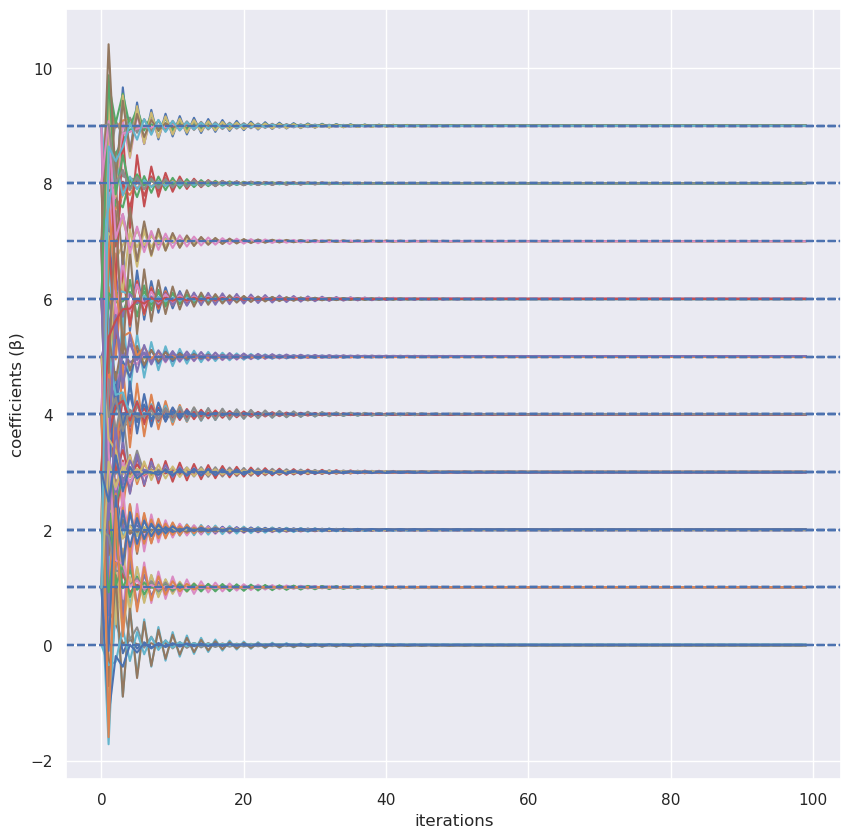

In [94]:
backfit_plot(n=650, p=100, iterations=100);

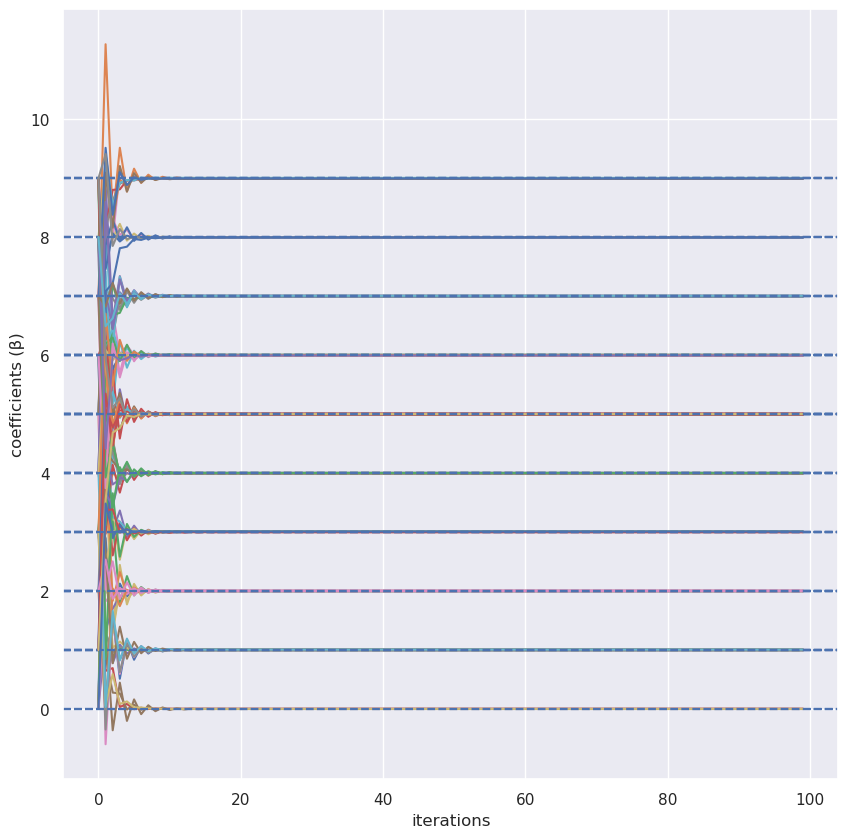

In [95]:
backfit_plot(n=1000, p=100, iterations=100);

In [96]:
interact(backfit_plot, 
         n=widgets.IntSlider(min=10, max=1000, step=20, value=100),
         p=widgets.IntSlider(min=2, max=100, step=5, value=10),
         iterations=widgets.IntSlider(min=10, max=20, step=10, value=10));

interactive(children=(IntSlider(value=100, description='n', max=1000, min=10, step=20), IntSlider(value=10, de…